Dataset Shape: (106, 3)
Structured Data Shape: (106, 58)


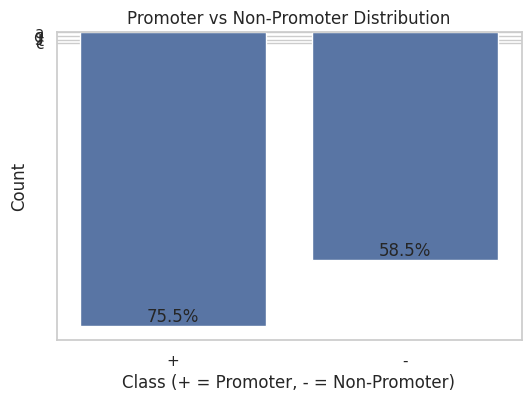

Encoded Dataset Shape: (106, 229)
Training Samples: 79
Testing Samples: 27
Model Performance:

KNN
Cross-Val Accuracy: 0.7857 (+/- 0.1112)
Test Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

       False       0.90      0.64      0.75        14
        True       0.71      0.92      0.80        13

    accuracy                           0.78        27
   macro avg       0.80      0.78      0.78        27
weighted avg       0.81      0.78      0.77        27

------------------------------------------------------------
Gaussian Process
Cross-Val Accuracy: 0.9000 (+/- 0.0935)
Test Accuracy: 0.9629629629629629
              precision    recall  f1-score   support

       False       1.00      0.93      0.96        14
        True       0.93      1.00      0.96        13

    accuracy                           0.96        27
   macro avg       0.96      0.96      0.96        27
weighted avg       0.97      0.96      0.96        27

---------------------

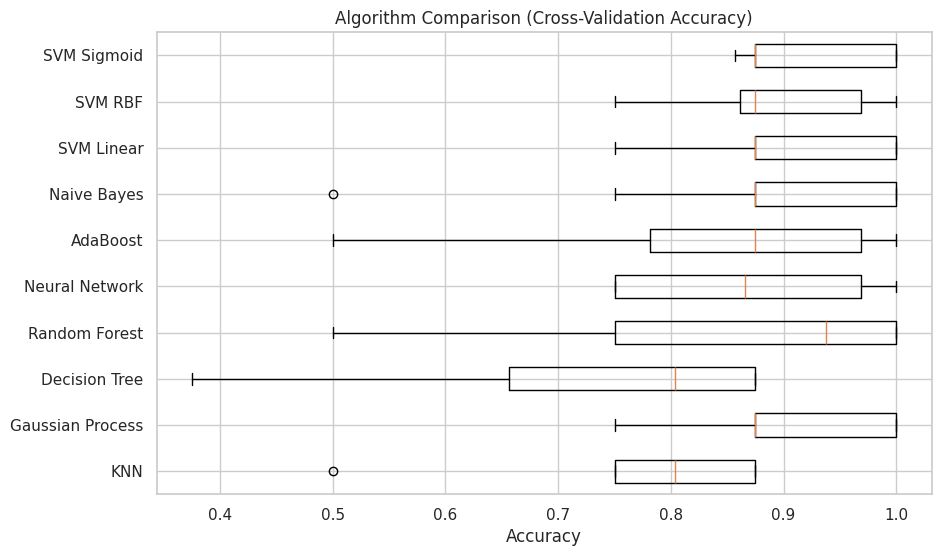

In [2]:
# ============================================================
# DNA Promoter Classification Project
# by S M Tanjimul Haque
# ============================================================

# ==============================
# 1. Import Required Libraries
# ==============================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Set visualization style
sns.set(style="whitegrid")


# ==============================
# 2. Load Dataset
# ==============================

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data"
column_names = ["Class", "ID", "Sequence"]

data = pd.read_csv(url, names=column_names)

print("Dataset Shape:", data.shape)
data.head()


# ==============================
# 3. Convert DNA Sequences to Structured Format
# ==============================

# Extract class labels
classes = data["Class"].values

# Extract sequences
sequences = data["Sequence"].values

# Create dictionary for processed dataset
processed_data = {}

for i, seq in enumerate(sequences):
    nucleotides = list(seq.strip())  # remove whitespace
    nucleotides.append(classes[i])   # append class label
    processed_data[i] = nucleotides

# Convert to DataFrame
df = pd.DataFrame.from_dict(processed_data, orient="index")

# Rename last column as 'Class'
df.rename(columns={df.columns[-1]: "Class"}, inplace=True)

print("Structured Data Shape:", df.shape)
df.head()


# ==============================
# 4. Visualize Target Variable
# ==============================

plt.figure(figsize=(6,4))
ax = sns.countplot(x="Class", data=df)
plt.title("Promoter vs Non-Promoter Distribution")
plt.xlabel("Class (+ = Promoter, - = Non-Promoter)")
plt.ylabel("Count")

# Add percentage labels
total = len(df)
for p in ax.patches:
    percentage = f"{100 * p.get_height()/total:.1f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()


# ==============================
# 5. One-Hot Encode DNA Sequences
# ==============================

# Convert categorical nucleotides into numeric form
numerical_df = pd.get_dummies(df)

# Drop one redundant class column
numerical_df = numerical_df.drop(columns=["Class_-"])

# Rename remaining class column
numerical_df.rename(columns={"Class_+": "Class"}, inplace=True)

print("Encoded Dataset Shape:", numerical_df.shape)
numerical_df.head()


# ==============================
# 6. Split Data
# ==============================

X = numerical_df.drop(columns=["Class"]).values
y = numerical_df["Class"].values

seed = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=seed, stratify=y
)

print("Training Samples:", X_train.shape[0])
print("Testing Samples:", X_test.shape[0])


# ==============================
# 7. Define Models
# ==============================

models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=50),
    "Neural Network": MLPClassifier(max_iter=500),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM Linear": SVC(kernel="linear"),
    "SVM RBF": SVC(kernel="rbf"),
    "SVM Sigmoid": SVC(kernel="sigmoid")
}


# ==============================
# 8. Cross Validation & Evaluation
# ==============================

results = []
model_names = []

print("Model Performance:\n")
print("="*60)

for name, model in models.items():

    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")

    results.append(cv_scores)
    model_names.append(name)

    print(f"{name}")
    print(f"Cross-Val Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Train and test evaluation
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    print("-"*60)


# ==============================
# 9. Model Comparison Visualization
# ==============================

plt.figure(figsize=(10,6))
plt.boxplot(results, vert=False)
plt.yticks(range(1, len(model_names) + 1), model_names)
plt.title("Algorithm Comparison (Cross-Validation Accuracy)")
plt.xlabel("Accuracy")
plt.show()
